# Extracting function

In [ ]:
from numpy import ones

def extract_hog(img):
    return ones(42)

def fit_and_classify(train_featues, train_labels, test_features):
    return ones(test_features.shape[0])



# write to python file 

In [11]:
%%writefile /Users/ahmad/Desktop/CompVision/03-sign-classification/code/fit_and_classify.py
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from skimage.filters import sobel_h, sobel_v
from skimage.transform import rescale, resize, downscale_local_mean

def extract_hog(img):
    img = resize(img, (48, 48))
    img_resized = img
    edgesHRed = sobel_h(img[:, :, 0])
    edgesHGreen = sobel_h(img[:, :, 1])
    edgesHBlue = sobel_h(img[:, :, 2])
    edgesVRed = sobel_v(img[:, :, 0])
    edgesVGreen = sobel_v(img[:, :, 1])
    edgesVBlue = sobel_v(img[:, :, 2])
    edgesRed = np.sqrt(np.square(edgesHRed) + np.square(edgesVRed))
    edgesGreen = np.sqrt(np.square(edgesHGreen) + np.square(edgesVGreen))
    edgesBlue = np.sqrt(np.square(edgesHBlue) + np.square(edgesVBlue))
    grad = np.zeros(img.shape[:-1])
    phi = np.zeros(grad.shape)
    for i in range(grad.shape[0]):
        for j in range(grad.shape[1]):
            grad[i][j] = np.amax([edgesRed[i][j], edgesGreen[i][j], edgesBlue[i][j]])
            ind = np.argmax([edgesRed[i][j], edgesGreen[i][j], edgesBlue[i][j]])
            if (ind == 0):
                phi[i][j] = np.arctan2(edgesHRed[i][j], edgesVRed[i][j])
            elif (ind == 1):
                phi[i][j] = np.arctan2(edgesHGreen[i][j], edgesVGreen[i][j])
            else:
                phi[i][j] = np.arctan2(edgesHBlue[i][j], edgesVBlue[i][j])
    phi = np.absolute(phi)

#     leastSide = min(img.shape[0], img.shape[1])

#     if (leastSide < 40):
#         img_resized = resize(img, (32, 32))
#     elif ((leastSide >= 40) and (leastSide < 48)):
#         img_resized = resize(img, (48, 48))
#     elif ((leastSide >= 48) and (leastSide < 56)):
#         img_resized = resize(img, (56, 56))
#     else:
#         img_resized = resize(img, (64, 64))

    x = img_resized.shape[0] // 8
    vector = np.zeros((x ** 2, 9))
    resVector = np.zeros(0)

    for i in range(0, x):
        for j in range(0, x):
            curPic = img_resized[i : (i + 8), j : (j + 8)]
            for k in range(8):
                for t in range(8):
                    sector = int((phi[8 * i + k, 8 * j + t] / (np.pi / 8)))
                    weight = ((phi[8 * i + k, 8 * j + t] - (np.pi / 8) * sector) / (np.pi / 8))
                    vector[i * x + j, sector] += weight * grad[i][j]
                    if (sector != 8):
                        vector[i * x + j, sector + 1] += (1 - weight) * grad[8 * i + k][8 * j + t]
                    else:
                        vector[i * x + j, 0] += (1 - weight) * grad[8 * i + k][8 * j + t]
    for i in range (x - 1):
        for j in range(x - 1):
            tempArr1 = np.append(vector[i * x + j], vector[i * x + j + 1])
            tempArr2 = np.append(vector[i * x + x + j], vector[i * x + x + j + 1])
            tempArr = np.append(tempArr1, tempArr2)
            s = np.square(tempArr)
            sumnorm = np.sum(s)
            tempArr = tempArr / (np.sqrt(np.sum(s) + 0.0002))
            resVector = np.append(resVector, tempArr)
    return resVector


#comment

def fit_and_classify(train_features, train_labels, test_features):
    from sklearn import svm
    clf = svm.LinearSVC()
    clf.fit(train_features, train_labels)
    data = clf.predict(test_features)
    return data


Overwriting /Users/ahmad/Desktop/CompVision/03-sign-classification/code/fit_and_classify.py


# testing function

In [8]:
#!/usr/bin/python3

import warnings
warnings.filterwarnings('ignore')

from sys import argv, exit
from numpy import zeros
from os.path import join
from fit_and_classify import fit_and_classify, extract_hog
from skimage.io import imread

def read_gt(gt_dir, ind):
    fgt = open(join(gt_dir, 'gt.csv'))
    next(fgt)
    lines = fgt.readlines()
    if (ind == 0):
        filenames = []
        labels = zeros((len(lines) // 53 + 1))
        for i, line in enumerate(lines):
            if (i % 53 == 0):
                filename, label = line.rstrip('\n').split(',')
                filenames.append(filename)
                labels[i // 53] = int(label)
    else:
        filenames = []
        labels = zeros(((len(lines) - 26) // 53 + 1))
        for i, line in enumerate(lines):
            if (i % 53 == 26):
                filename, label = line.rstrip('\n').split(',')
                filenames.append(filename)
                labels[i // 53] = int(label)
    return filenames, labels


def extract_features(path, filenames):
    hog_length = len(extract_hog(imread(join(path, filenames[0]), plugin='matplotlib')))
    data = zeros((len(filenames), hog_length))
    k = 0
    for i in range(0, len(filenames)):
        filename = join(path, filenames[i])
        data[i, :] = extract_hog(imread(filename, plugin='matplotlib'))
        if ((i // 392) > k):
            print("Extracting features: ", i // 392, " %")
            k = k + 1
    return data

if len(argv) != 3:
    print('Usage: %s train_data_path test_data_path' % argv[0])
    exit(0)

train_data_path = '/Users/ahmad/Desktop/CompVision/03-sign-classification/data/train'
test_data_path = '/Users/ahmad/Desktop/CompVision/03-sign-classification/data/train'

train_filenames, train_labels = read_gt(train_data_path, 0)
test_filenames, test_labels = read_gt(test_data_path, 1)

train_features = extract_features(train_data_path, train_filenames)
test_features = extract_features(test_data_path, test_filenames)

y = fit_and_classify(train_features, train_labels, test_features)
print('Accuracy: %.4f' % (sum(test_labels == y) / float(test_labels.shape[0])))



Extracting features:  1  %
Extracting features:  1  %
Accuracy: 0.6986


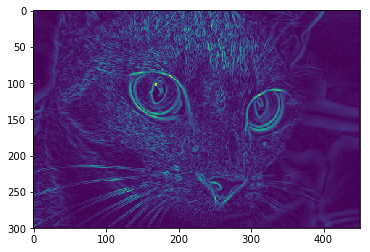

In [9]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel, sobel_h, sobel_v
from skimage import data

cat = data.chelsea()
catEdgesRed = sobel(cat[:, :, 0])
catEdgesGreen = sobel(cat[:, :, 1])
catEdgesBlue = sobel(cat[:, :, 2])
grad = np.maximum(catEdgesRed, catEdgesGreen, catEdgesBlue)
plt.imshow(grad)

In [6]:
%matplotlib inline

import numpy as np
from skimage.filters import sobel_h, sobel_v
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data
import matplotlib.pyplot as plt
from numpy import linalg as LA

img = data.chelsea()
edgesHRed = sobel_h(img[:, :, 0])
edgesHGreen = sobel_h(img[:, :, 1])
edgesHBlue = sobel_h(img[:, :, 2])
edgesVRed = sobel_v(img[:, :, 0])
edgesVGreen = sobel_v(img[:, :, 1])
edgesVBlue = sobel_v(img[:, :, 2])
edgesRed = np.sqrt(np.square(edgesHRed) + np.square(edgesVRed))
edgesGreen = np.sqrt(np.square(edgesHGreen) + np.square(edgesVGreen))
edgesBlue = np.sqrt(np.square(edgesHBlue) + np.square(edgesVBlue))
grad = np.zeros(img.shape[:-1])
phi = np.zeros(grad.shape)
for i in range(grad.shape[0]):
    for j in range(grad.shape[1]):
        grad[i][j] = np.amax([edgesRed[i][j], edgesGreen[i][j], edgesBlue[i][j]])
        ind = np.argmax([edgesRed[i][j], edgesGreen[i][j], edgesBlue[i][j]])
        if (ind == 0):
            phi[i][j] = np.arctan2(edgesHRed[i][j], edgesVRed[i][j])
        elif (ind == 1):
            phi[i][j] = np.arctan2(edgesHGreen[i][j], edgesVGreen[i][j])
        else:
            phi[i][j] = np.arctan2(edgesHBlue[i][j], edgesVBlue[i][j])
phi = np.absolute(phi)

# leastSide = min(img.shape[0], img.shape[1])

# if (leastSide < 40):
#     img_resized = resize(img, (32, 32))
# elif ((leastSide >= 40) and (leastSide < 48)):
#     img_resized = resize(img, (48, 48))
# elif ((leastSide >= 48) and (leastSide < 56)):
#     img_resized = resize(img, (56, 56))
# else:
#     img_resized = resize(img, (64, 64))
img_resized = resize(img, (48, 48))

x = img_resized.shape[0] // 8
vector = np.zeros((x ** 2, 9))
resVector = np.zeros(0)

for i in range(0, x):
    for j in range(0, x):
        curPic = img_resized[i : (i + 8), j : (j + 8)]
        for k in range(8):
            for t in range(8):
                sector = int((phi[8 * i + k, 8 * j + t] / (np.pi / 8)))
                weight = ((phi[8 * i + k, 8 * j + t] - (np.pi / 8) * sector) / (np.pi / 8))
                vector[i * x + j, sector] += weight * grad[i][j]
                if (sector != 8):
                    vector[i * x + j, sector + 1] += (1 - weight) * grad[8 * i + k][8 * j + t]
                else:
                    vector[i * x + j, 0] += (1 - weight) * grad[8 * i + k][8 * j + t]
for i in range (x - 1):
    for j in range(x - 1):
        tempArr1 = np.append(vector[i * x + j], vector[i * x + j + 1])
        tempArr2 = np.append(vector[i * x + x + j], vector[i * x + x + j + 1])
        tempArr = np.append(tempArr1, tempArr2)
        norm = LA.norm(tempArr)
        tempArr = tempArr / norm
        resVector = np.append(resVector, tempArr)

resVector.shape

(900,)

In [31]:
import numpy
numpy.pi
np.zeros(0)

array([], dtype=float64)

In [52]:
from sklearn import svm
X = [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]] # features
y = [0, 2, 4, 6, 8] # labels
clf = svm.SVC() # SVM
clf.fit(X, y) # making prediction model
clf.predict([[4, 4], [3, 3]]) # using prediction model

array([8, 6])

In [5]:
import numpy as np
sml = np.array(((1., 2., 3.), (4., 5., 6.), (7., 8., 9.)))
from skimage.transform import rescale, resize
med = resize(sml, (10, 10))
med

/Users/ahmad/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[ 1.    ,  1.    ,  1.    ,  1.0075,  1.2025,  1.3975,  1.5925,
         1.7875,  1.8525,  1.2675],
       [ 1.    ,  1.    ,  1.1875,  1.4725,  1.7575,  2.0425,  2.3275,
         2.6125,  2.7075,  1.8525],
       [ 1.1375,  1.6625,  2.    ,  2.3   ,  2.6   ,  2.9   ,  3.2   ,
         3.5   ,  3.5625,  2.4375],
       [ 1.7225,  2.5175,  2.9   ,  3.2   ,  3.5   ,  3.8   ,  4.1   ,
         4.4   ,  4.4175,  3.0225],
       [ 2.3075,  3.3725,  3.8   ,  4.1   ,  4.4   ,  4.7   ,  5.    ,
         5.3   ,  5.2725,  3.6075],
       [ 2.8925,  4.2275,  4.7   ,  5.    ,  5.3   ,  5.6   ,  5.9   ,
         6.2   ,  6.1275,  4.1925],
       [ 3.4775,  5.0825,  5.6   ,  5.9   ,  6.2   ,  6.5   ,  6.8   ,
         7.1   ,  6.9825,  4.7775],
       [ 4.0625,  5.9375,  6.5   ,  6.8   ,  7.1   ,  7.4   ,  7.7   ,
         8.    ,  7.8375,  5.3625],
       [ 4.3225,  6.3175,  6.8875,  7.1725,  7.4575,  7.7425,  8.0275,
         8.3125,  8.1225,  5.5575],
       [ 2.9575,  4.3225,  4.7125,  4

In [ ]:
21:03 - laucnh time


In [10]:
import numpy as np
a = np.array([0., 1., 2., 3.])
tempArr = a
s = np.square(tempArr)
sumnorm = np.sum(s)
tempArr = tempArr / (np.sqrt(sumnorm + 0.000001))
tempArr

array([ 0.        ,  0.26726123,  0.53452246,  0.8017837 ])